# Installing the package and getting help

The `seux` package can be installed by pointing to the directory that the `seux` repo is in. It provides some functions and a help page is available for each function.

In [56]:
# install.packages("../seux", repos = NULL, type="source") # -- for the first time
library("seux")
lsf.str("package:seux")

central_hyper_midP : function (U0, S0, S1, U1, d0)  
check_frst_last_detns : function (frstDetn, lastDetn)  
find_U0_bnd : function (midP_fnc, alpha, S0, S1, U1, d0, impossibleFlag = FALSE)  
get_CI_estimate : function (S, E, nreps = 10000, percentile = 95, U_T = 0, midP_fnc = NULL)  
get_first_last_detections_from_csv : function (fName, frst_col, last_col)  
get_model_inputs : function (frstDetn, lastDetn, collapse_timesteps = TRUE, y0 = NULL, yf = NULL)  
get_old_estimate : function (S, E, U_T = 0)  

In [57]:
?get_first_last_detections_from_csv

![title](get_from_csv_help.png)

# Quick start example

For this example, we'll use the detections record for birds in Singapore from Chisholm et al. (2016).

In [58]:
fName <- "example_data/AppendixS5birdspecieslistSingapore.csv"
raw_data <- read.csv(fName,header=T)
head(raw_data)

Common.Name            Name                                First.record
1 Blue-breasted Quail    Coturnix chinensis chinensis        1819        
2 Red Junglefowl         Gallus gallus spadiceus             1985        
3 Lesser Whistling-duck  Dendrocygna javanica                1977        
4 Barred Buttonquail     Turnix suscitator atrogularis       1819        
5 Sunda Pygmy Woodpecker Dendrocopos moluccensis moluccensis 1819        
6 Rufous Woodpecker      Celeus brachyurus squamigularis     1819        
  Last.record X 
1 2014        NA
2 2014        NA
3 2014        NA
4 2014        NA
5 2014        NA
6 2014        NA

The SEUX model needs the first and last detections, so we'll make a note of where they are. We can use either the column number or the column header.

In [59]:
frst_col <- 3
last_col <- "Last record"

The usual workflow steps are:
1. The `detection_record` of first and last detections of each species is read from a `.csv`;
1. The `model_inputs`, which is a timeseries of $S$ (detected extant) and $E$ (detected extinct), is created from the `detection_record`;
1. Confidence intervals and estimates for the unknown $U$ (undetected extant) and $X$ (undetected extinct) can be obtained using the central hypergeometric SEUX model;
1. Estimates using the method published in Chisholm et al. (2016) can also be obtained.

In [60]:
detection_record <- get_first_last_detections_from_csv(fName, frst_col, last_col)           # 1
model_inputs     <- get_model_inputs( detection_record$frstDetn, detection_record$lastDetn) # 2
CIs_estimates    <- get_CI_estimate( model_inputs$S, model_inputs$E)                        # 3
old_estimates    <- get_old_estimate( model_inputs$S, model_inputs$E )                      # 4

df <- cbind(model_inputs, CIs_estimates, old_estimates)

The outputs from the models can be plotted using something similar to below.

In [61]:
library(ggplot2)

plot_output <- function(df) {
    
    p <- ggplot(df) + 
     geom_line(aes(year, S,      color="S", linetype="data")) + 
     geom_line(aes(year, E,      color="E", linetype="data")) + 
     geom_line(aes(year, U_mean, color="U", linetype="hyper")) + 
     geom_line(aes(year, U_old,  color="U", linetype="old")) + 
     geom_line(aes(year, X_mean, color="X", linetype="hyper")) + 
     geom_line(aes(year, X_old,  color="X", linetype="old")) +
     scale_color_manual(name="Species class", 
                       values=c(
                                "S"     = "darkgreen", 
                                "E"     = "red",
                                "U"     = "orange",
                                "X"     = "blue"
                                ),
                       labels=c(
                                "S"     = expression(S[t]),
                                "E"     = expression(E[t]),
                                "U"     = expression(U[t]),
                                "X"     = expression(X[t])
                                )
                       ) +
     scale_linetype_manual(name="Method of inferrence", 
                       values=c(
                                "data"  = "solid", 
                                "hyper" = "longdash",
                                "old"   = "dotted"
                                ),
                       labels=c(
                                "data"  = "from data",
                                "hyper" = "hypergeometric",
                                "old"   = "Chisholm et al. (2016)"
                                )
                       ) +
     geom_ribbon(aes(x=year, ymin=X_lo, ymax=X_hi), fill="blue", alpha="0.3") +
     geom_ribbon(aes(x=year, ymin=U_lo, ymax=U_hi), fill="orange", alpha="0.3") +
     xlab('years') +
     ylab('number of species') +
     theme_bw()
    
    return(p)
        
    }

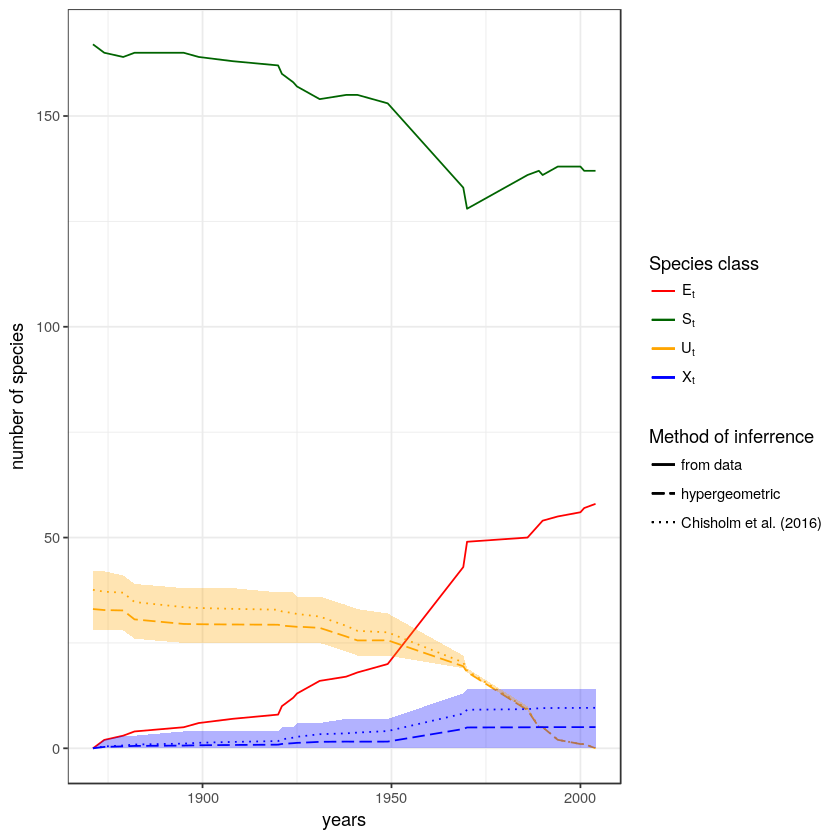

In [62]:
the_plot <- plot_output(df)
print(the_plot)

# Modifying default behaviour

## Collapse of timesteps

The default behaviour in `seux` is to collapse timesteps within the timeseries so that every timestep has at least one detected extinction. This occurs in the `get_model_inputs()` function. For example, the above model inputs, you'll see that the `year` column counts up in uneven increments:



In [63]:
head(model_inputs)

year S   E d
1 1871 167 0 0
2 1874 165 2 0
3 1879 164 3 2
4 1882 165 4 1
5 1895 165 5 0
6 1899 164 6 0

You can turn this default behaviour off using the `collapse_timestep` input.

In [64]:
model_inputs_nocollapse <- get_model_inputs(detection_record$frstDetn, 
                                            detection_record$lastDetn, 
                                            collapse_timesteps=FALSE)
head(model_inputs_nocollapse)

year S   E d
1 1871 167 0 0
2 1872 165 2 0
3 1873 165 2 0
4 1874 165 2 0
5 1875 164 3 0
6 1876 164 3 0

Rerunning the model produces different results.

In [65]:
CIs_estimates_nocollapse <- get_CI_estimate( model_inputs_nocollapse$S, model_inputs_nocollapse$E )
old_estimates_nocollapse <- get_old_estimate( model_inputs_nocollapse$S, model_inputs_nocollapse$E )

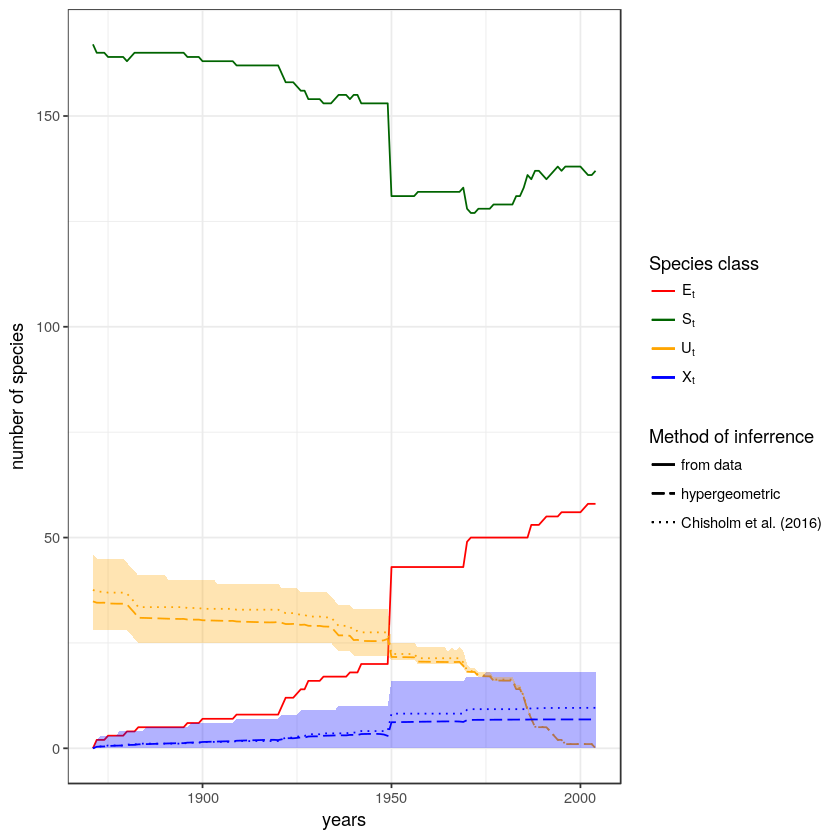

In [66]:
df_nocollapse <- cbind(model_inputs_nocollapse, CIs_estimates_nocollapse, old_estimates_nocollapse)
the_plot <- plot_output(df_nocollapse)
print(the_plot)

## Start and end times of the timeseries

The default behaviour in `seux` is to start the timeseries with the first detected extinction, and to end it with the last detected extinction or the last new discovery-- whichever is later. The extent of the timeseries can be modified using `get_model_inputs`.

In [67]:
print(min(detection_record$frstDetn))
print(max(detection_record$lastDetn))

[1] 1819
[1] 2014


In [68]:
model_inputs_longer <- get_model_inputs(detection_record$frstDetn, 
                                        detection_record$lastDetn, 
                                        collapse_timesteps=FALSE,
                                        y0=1819,
                                        yf=2014
                                       )
head(model_inputs_longer)

year S   E d
1 1819 167 0 0
2 1820 167 0 0
3 1821 167 0 0
4 1822 167 0 0
5 1823 167 0 0
6 1824 167 0 0

In [69]:
tail(model_inputs_longer)

year S   E  d 
191 2009 137 58  0
192 2010 137 58  0
193 2011 137 58  0
194 2012 137 58  0
195 2013 137 58  0
196 2014 137 58 NA

In [70]:
CIs_estimates_longer <- get_CI_estimate( model_inputs_longer$S, model_inputs_longer$E, nreps=1000 ) # 1000 -- speed up
old_estimates_longer <- get_old_estimate( model_inputs_longer$S, model_inputs_longer$E )

Notice that the hypergeometric model (i.e. the output from `get_CI_estimate()`) allows for undetected extinctions to occur even while no detected extinctions occurs. This makes sense -- just because we didn't see any extinctions occurring doesn't mean that extinctions weren't occurring.

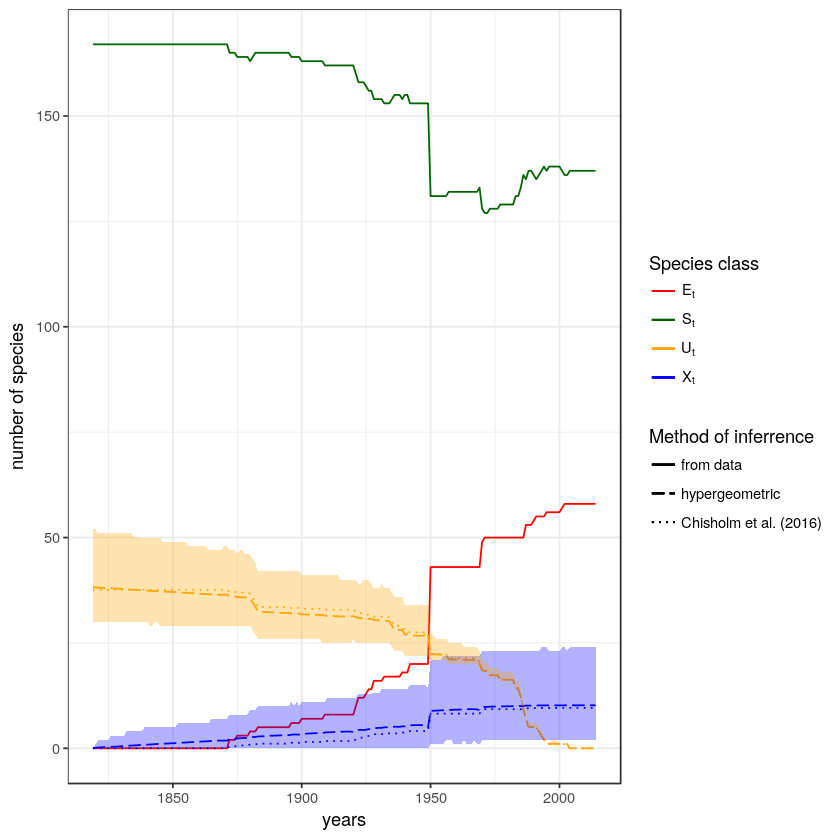

In [71]:
df_longer <- cbind(model_inputs_longer, CIs_estimates_longer, old_estimates_longer)
the_plot <- plot_output(df_longer)
print(the_plot)

## Assumption that no undetected extant species remain

The default behaviour in `seux` is to assume that at the end of the timeseries, no undetected species remain ($U_T=0$). You may wish to explore the effect of this assumption, or may wish to account for known species that are not included in the detection record. The default can be changed in both the `get_CI_estimate()` and `get_old_estimate()` functions.

In [72]:
CIs_estimates_UT100 <- get_CI_estimate( model_inputs$S, model_inputs$E, U_T=100 )
old_estimates_UT100 <- get_old_estimate( model_inputs$S, model_inputs$E, U_T=100 )

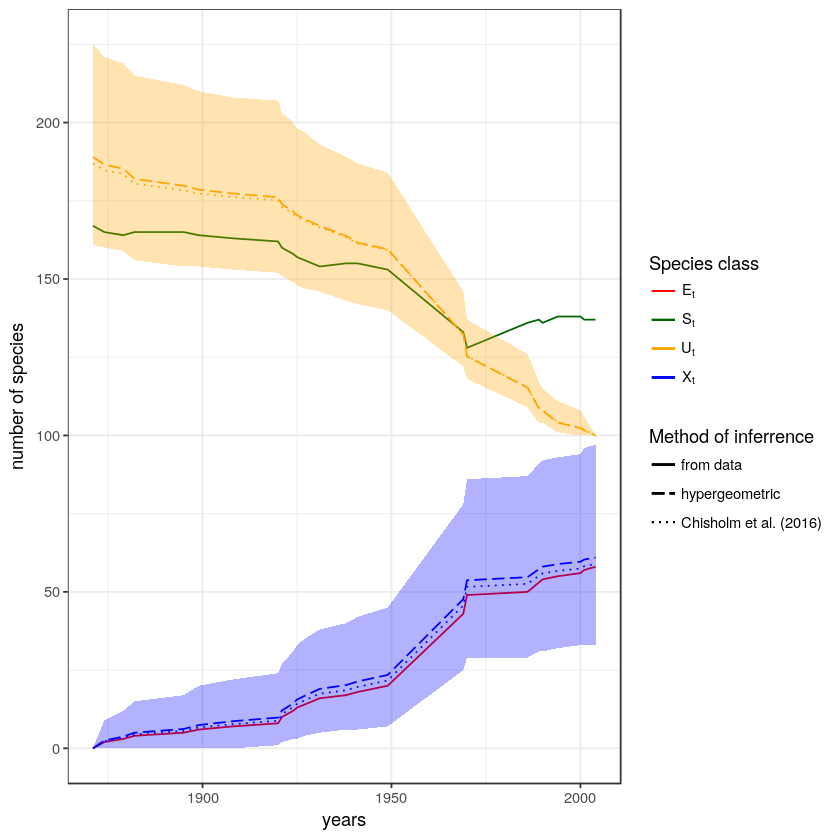

In [73]:
df_UT100 <- cbind(model_inputs, CIs_estimates_UT100, old_estimates_UT100)

the_plot <- plot_output(df_UT100)
print(the_plot)

## Assumes a central hypergeometric function

The default behaviour in `seux` is to assume that the SEUX model can be represented with a central hypergeometric distribution model. In short, this assumes that the probability of extinction for detected and undetected species is the same.

This default behaviour can be modified by specifying a new `midP_fnc` as input to the `get_CI_estimate()` function.

For example, we may wish to use a biased urn model, such that the undetected species have a lower probability of surviving each timestep than the detected species. The [Fisher's noncentral hypergeometric distribution](https://en.wikipedia.org/wiki/Fisher%27s_noncentral_hypergeometric_distribution) can be used to create such a model. It has one extra parameter, $\omega$, which is the odds ratio

$$ \omega = \frac{ P(\text{survival of undetecteds}) / (1-P(\text{survival of undetecteds}))}
{P(\text{survival of detecteds}) / (1-P(\text{survival of detecteds}))} $$

Below we'll set the parameter $\omega = 0.3$.

In [74]:
# install.packages("BiasedUrn") # -- first time
library(BiasedUrn)

midP_fnc <- function(U0, S0, S1, U1, d0){
    
    omega <- 0.3 # odds ratio
    alpha <- 0.5 * ( pFNCHypergeo( U1+d0, U0, S0, S1+U1, omega ) + pFNCHypergeo( U1+d0-1, U0, S0, S1+U1, omega) )
    
    return(alpha)
}

The `midP_fnc` that we define can be used as an input to the `get_CI_estimates()` function.

In [75]:
CIs_estimates_biasedurn <- get_CI_estimate( model_inputs$S, model_inputs$E, midP_fnc=midP_fnc, nreps=100)

As we'd expect, the number of undetected extinctions in the SEUX increases.

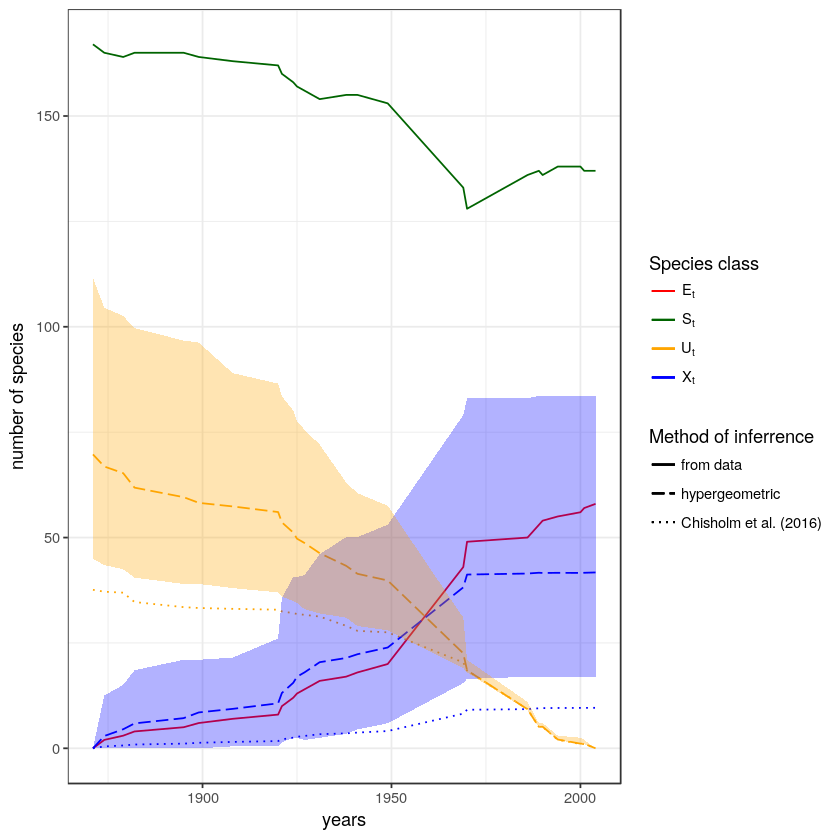

In [76]:
df_biasedurn <- cbind(model_inputs, CIs_estimates_biasedurn, old_estimates)
the_plot <- plot_output(df_biasedurn)
print(the_plot)

# More examples

## Butterflies

In [77]:
fName <- "example_data/butterfly_input.csv"
raw_data <- read.csv(fName,header=T)
head(raw_data)

Name                           First.Record Last.Record
1 Eulaceura osteria kumana       1901         2017       
2 Euripus nyctelius euploeoides  1882         2017       
3 Charaxes bernardus crepax      1900         1961       
4 Charaxes solon echo            1876         2017       
5 Polyura hebe plautus           1898         2017       
6 Polyura schreiber tisamenus    1900         2017

In [78]:
frst_col <- "First Record"
last_col <- "Last Record"

Default settings:

In [80]:
detection_record <- get_first_last_detections_from_csv(fName, frst_col, last_col)
model_inputs <- get_model_inputs( detection_record$frstDetn, detection_record$lastDetn )
CIs_estimates <- get_CI_estimate( model_inputs$S, model_inputs$E )
old_estimates <- get_old_estimate( model_inputs$S, model_inputs$E )

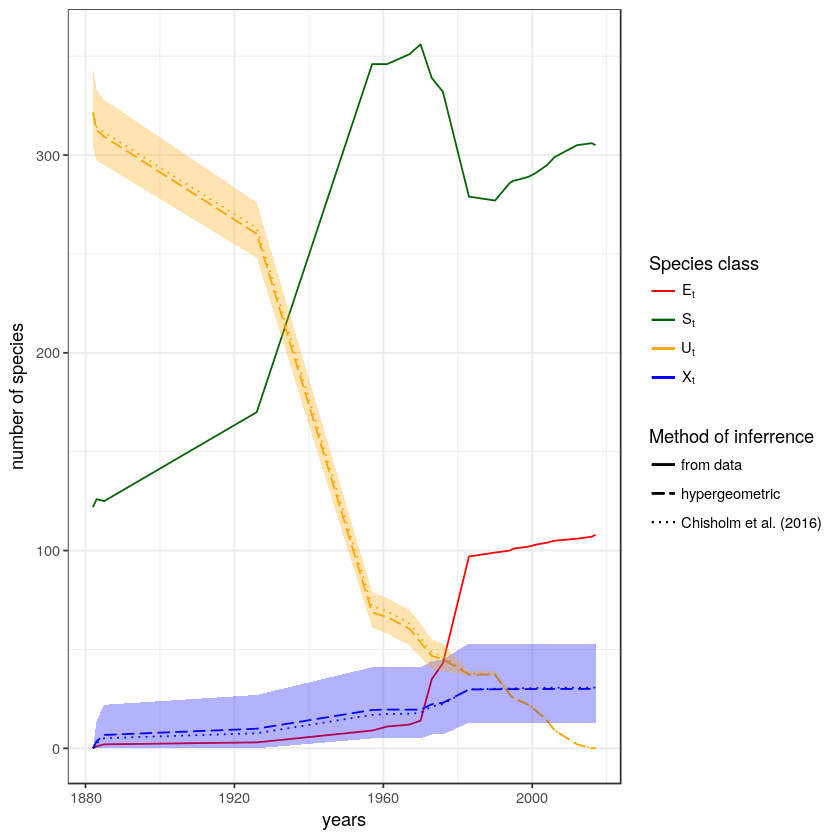

In [81]:
df <- cbind(model_inputs, CIs_estimates, old_estimates)
the_plot <- plot_output(df)
print(the_plot)

Don't collapse the timesteps

In [82]:
model_inputs_nocollapse <- get_model_inputs(
    detection_record$frstDetn, 
    detection_record$lastDetn, 
    collapse_timesteps=FALSE)
CIs_estimates_nocollapse <- get_CI_estimate( model_inputs_nocollapse$S, model_inputs_nocollapse$E)
old_estimates_nocollapse <- get_old_estimate( model_inputs_nocollapse$S, model_inputs_nocollapse$E )

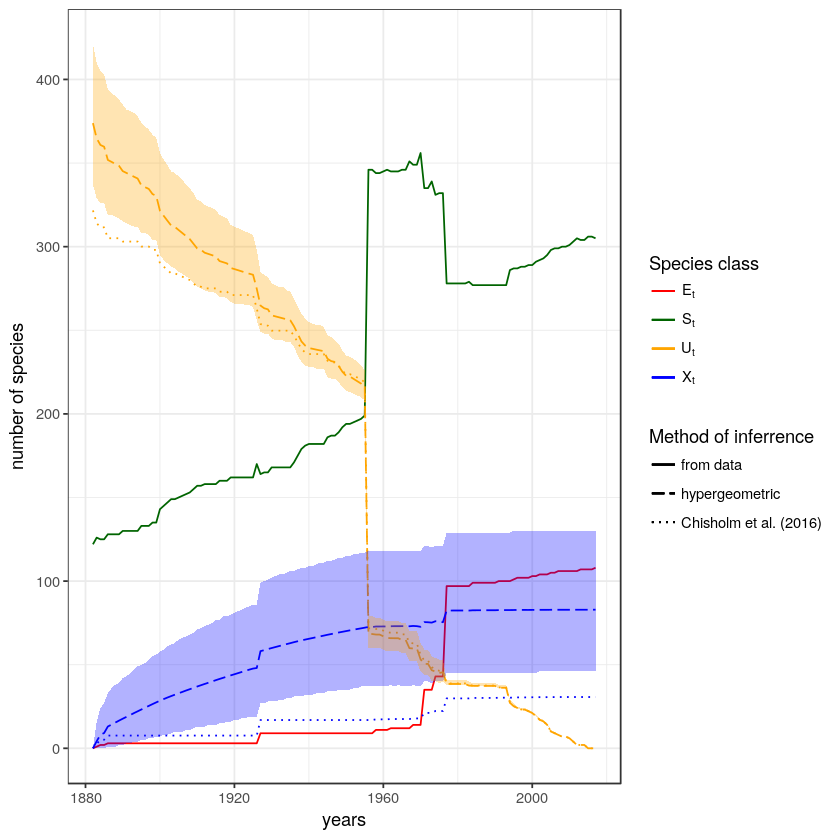

In [83]:
df_nocollapse <- cbind(model_inputs_nocollapse, CIs_estimates_nocollapse, old_estimates_nocollapse)
the_plot <- plot_output(df_nocollapse)
print(the_plot)

## Australian amphibians

In [84]:
fName <- "example_data/AUS_Amphibians.csv"
raw_data <- read.csv(fName,header=T)
head(raw_data)

Species                    Description.year Extinction.year
1 Adelotus.brevis            1863             NA             
2 Arenophryne.rotunda        1976             NA             
3 Assa.darlingtoni           1933             NA             
4 Austrochaperina.adelphe    1985             NA             
5 Austrochaperina.fryi       1962             NA             
6 Austrochaperina.gracilipes 1912             NA

Have two columns of interest: `Description.year` and `Extinction.year`. It appears that `Extinction.year` has an `NA` if the species is not extinct. 

We will set the final year of the timeseries to last year recorded in the data file plus 1.

In [85]:
yf <- max( c( max(raw_data$Description.year), max(raw_data$Extinction.year, na.rm=TRUE) ) ) + 1

Make the non-extinct species last detected in `yf`, otherwise, last detection was year before extinction year.


In [86]:
Last.year <- sapply( raw_data$Extinction.year, function(y) if ( is.na(y) ) { yf } else { y-1 } )

Add `Last.year` to our old raw data to make new modified data frame.

In [87]:
mod_data <- cbind( raw_data, Last.year )
head(mod_data)

Species                    Description.year Extinction.year Last.year
1 Adelotus.brevis            1863             NA              2008     
2 Arenophryne.rotunda        1976             NA              2008     
3 Assa.darlingtoni           1933             NA              2008     
4 Austrochaperina.adelphe    1985             NA              2008     
5 Austrochaperina.fryi       1962             NA              2008     
6 Austrochaperina.gracilipes 1912             NA              2008

We can peform some basic checks on the first and last detections data. The function `check_frst_last_detns()` will return `FALSE` and a message if it finds a problem with the detection record.

In [88]:
res <- check_frst_last_detns( mod_data$Description.year, mod_data$Last.year )
res

$flag
[1] TRUE

$message
[1] ""

The check performed in `check_frst_last_detns()` is also performed by `get_model_inputs()` below.

Run the model and plot.

In [89]:
model_inputs <- get_model_inputs( mod_data$Description.year, mod_data$Last.year, collapse_timesteps=FALSE)
CIs_estimates <- get_CI_estimate( model_inputs$S, model_inputs$E, nreps=1000)
old_estimates <- get_old_estimate( model_inputs$S, model_inputs$E )

Warning message:
“Removed 23 rows containing missing values (geom_path).”Warning message:
“Removed 20 rows containing missing values (geom_path).”

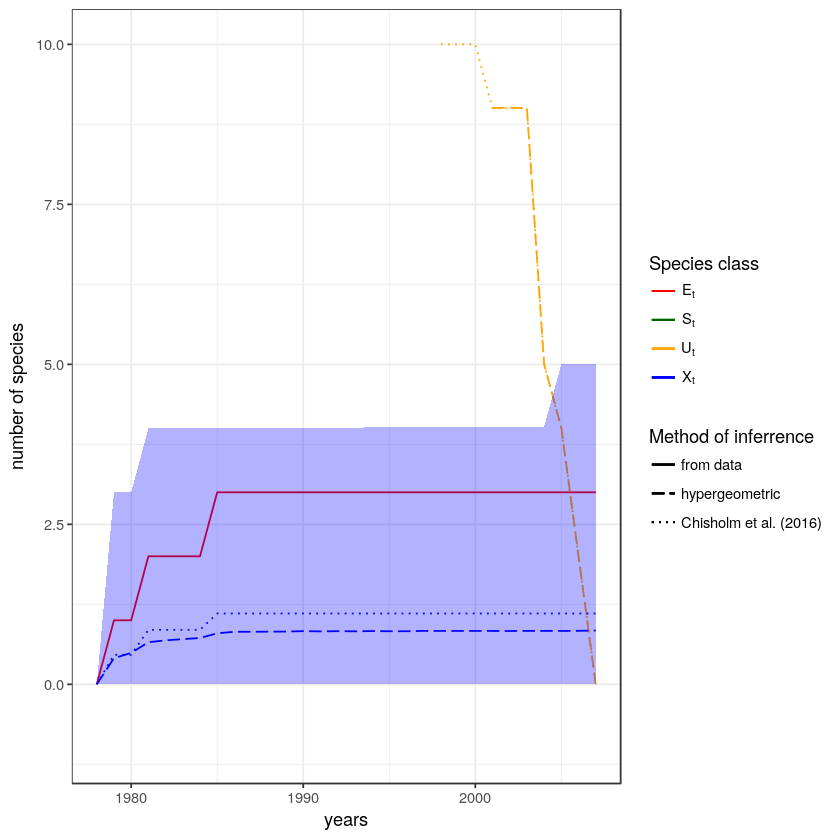

In [90]:
df <- cbind(model_inputs, CIs_estimates, old_estimates)
the_plot <- plot_output(df)
the_plot <- the_plot + ylim(-1,10)
print(the_plot)

## Finding U bounds

In this example we see how a U bound is sampled.

The plot below shows how the confidence level varies with `U0` (blue points). The $\alpha$ value is the horizontal line, which may be a randomly-sampled confidence level. The $U_0$ bound is the greatest value for which the mid-P function evaluates $>= \alpha$, analogous to find the upper confidence bound. `U0_bnd` is therefore the right-most blue point that is above the horizontal $\alpha$ line. The `U0_bnd` that is found using the function `find_U0_bnd()` is shown as a vertical dashed line, which intersects the `U0_bnd` that one would identify graphically.


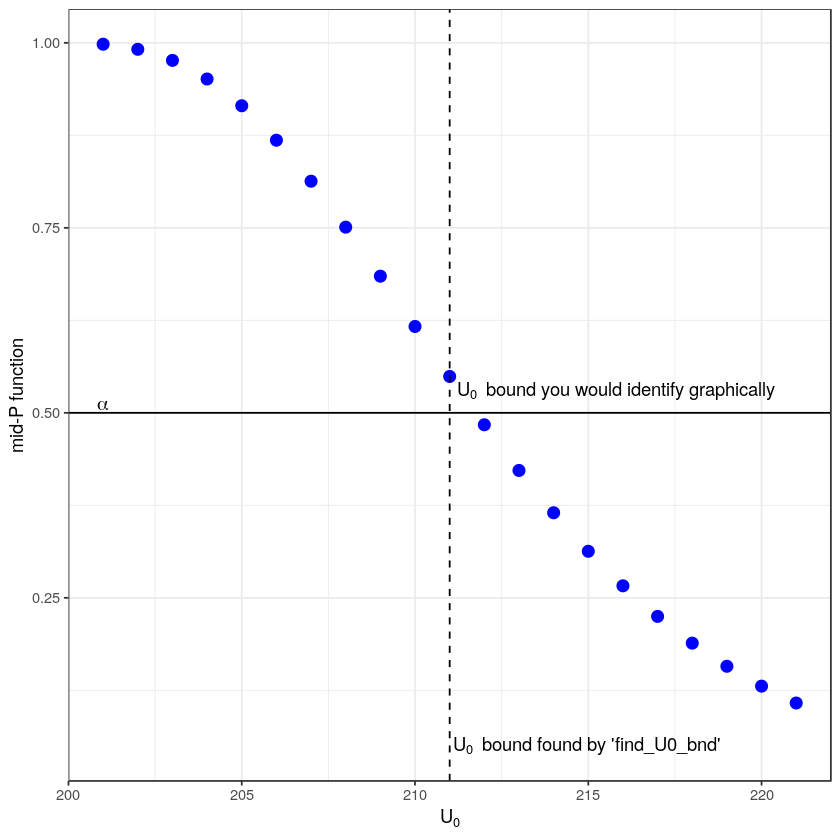

In [92]:
# some parameters
S0 <- 100; S1 <- 96; d0 <- 1    # from the data
U1 <- 200;                      # from an earlier timestep in the algorithm
alpha <- 0.5;                   # may be a randomly-sampled confidence level
midP_fnc <- central_hyper_midP

# find the sampled U_0 bound
res <- find_U0_bnd(midP_fnc, alpha, S0, S1, U1, d0)
U0_bnd <- res$U0_bnd

# check the bound against a plot

min_poss_U0 <- U1 + d0
U0V <- seq(min_poss_U0, U0_bnd+10, by=1)                                        # a range of possible U0 values
alphaV <- sapply( U0V, function(U0) central_hyper_midP(U0, S0, S1, U1, d0) )    # the alpha value at each U0
df <- data.frame( U0=U0V, alpha=alphaV )                                        # ggplot wants it as a dataframe

ggplot(df, aes(U0,alpha)) +
 theme_bw() + 
 geom_point(size=3, color="blue") +
 labs(x = expression(U[0]), y = "mid-P function") +
 geom_hline(yintercept=alpha, linetype="solid", color = "black") +
 geom_vline(xintercept=U0_bnd, linetype="dashed", color = "black") +
 annotate("text", x = min(U0V), y = alpha+0.01, parse=T, 
          label = as.character(expression(alpha))) +
 annotate("text", x = U0_bnd+0.1, y = 0.05, hjust=0, parse=T, 
          label = as.character(expression(U[0]~"bound found by 'find_U0_bnd'"))) +
 annotate("text", x = U0_bnd+0.2, y = alpha+0.03, hjust=0, parse=T, 
          label = as.character(expression(U[0]~"bound you would identify graphically")))